In [1]:
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 13.7 MB/s eta 0:00:00


In [2]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import optimizers
from keras.layers import Dense
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from pandas import ExcelFile
from pandas import ExcelWriter
from PIL import Image
from scipy import ndimage
from scipy.stats import randint as sp_randint
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets
from sklearn import metrics
from sklearn import pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from tensorflow.python.framework import ops
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import pandas as pd
import scipy
import tensorflow as tf
import xlsxwriter

import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


import keras.backend as K
%load_ext autoreload
%matplotlib inline

In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 50.5 MB/s eta 0:00:00


In [4]:
from __future__ import print_function
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
 
from matplotlib import pyplot as plt
%matplotlib inline
print("RDKit: %s"%rdkit.__version__)

RDKit: 2022.09.5


In [5]:
import keras
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
print("Keras: %s"%keras.__version__)

Keras: 2.12.0


In [6]:
data = pd.read_excel(r'/content/IGC50.xlsx')

In [7]:
data["mol"] = data["smiles"].apply(Chem.MolFromSmiles)

0       <rdkit.Chem.rdchem.Mol object at 0x7fd44dcfa030>
1       <rdkit.Chem.rdchem.Mol object at 0x7fd44dcf9ee0>
2       <rdkit.Chem.rdchem.Mol object at 0x7fd44dcf97e0>
3       <rdkit.Chem.rdchem.Mol object at 0x7fd44dcf98c0>
4       <rdkit.Chem.rdchem.Mol object at 0x7fd44dcf9d20>
                              ...                       
1787    <rdkit.Chem.rdchem.Mol object at 0x7fd44d436ff0>
1788    <rdkit.Chem.rdchem.Mol object at 0x7fd44d437060>
1789    <rdkit.Chem.rdchem.Mol object at 0x7fd44d4370d0>
1790    <rdkit.Chem.rdchem.Mol object at 0x7fd44d437140>
1791    <rdkit.Chem.rdchem.Mol object at 0x7fd44d4371b0>
Name: mol, Length: 1792, dtype: object

In [8]:
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    #print(dims)
   
    #print(mol)
    #print(",,,,,,,,,,,,,,,,,,,,,,")
    cmol = Chem.Mol(mol.ToBinary())
    #print(cmol)
    #print(",,,,,,,,,,,,,,,,,,,,,,")
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    #print(coords)
    #print(",,,,,,,,,,,,,,,,,,,,,,")
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
            
    return vect

(100, 100, 4)


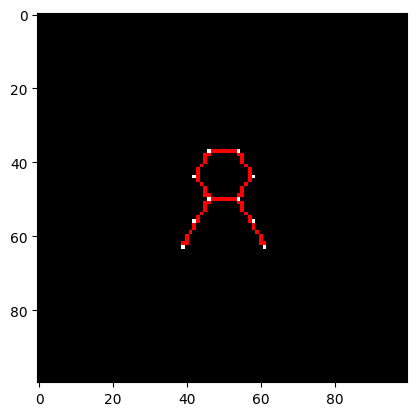

In [9]:
mol = data["mol"][104]
v = chemcepterize_mol(mol, embed=10, res=0.2)

print(v.shape)
plt.imshow(v[:,:,:3])    


In [10]:
def vectorize(mol):
    return chemcepterize_mol(mol, embed=12)
data["molimage"] = data["mol"].apply(vectorize)

In [81]:
smiles_str = "CC(=O)OC1=CC=CC=C1C(=O)O"
mol = Chem.MolFromSmiles(smiles_str)
#smiles_str.apply(Chem.MolFromSmiles)
l=chemcepterize_mol(mol, embed=20.0, res=0.5)
l.shape

(80, 80, 4)

In [84]:
l=vectorize(mol)
l.shape

(48, 48, 4)

In [11]:
X_train = np.array(list(data["molimage"][data["split"]==1]))
X_test = np.array(list(data["molimage"][data["split"]==0]))
print(X_train.shape)
print(X_test.shape)

(1434, 48, 48, 4)
(358, 48, 48, 4)


In [ ]:
print(X_train)

In [12]:
assay = "Activity"
y_train = data[assay][data["split"]==1].values.reshape(-1,1)
y_test = data[assay][data["split"]==0].values.reshape(-1,1)

In [13]:
print(np.shape(y_train))

(1434, 1)


In [14]:
input_shape = X_train.shape[1:]
print(input_shape)
from keras.layers import Dense, Dropout

(48, 48, 4)


In [15]:
def Inception0(input):
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
 
    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
 
    tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
 
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    return output

In [16]:
def Inception(input):
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
 
    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
 
    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
    tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)
 
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    return output

In [17]:
input_img = Input(shape=input_shape)
 
x = Inception0(input_img)
x = Inception(x)
x = Inception(x)
od=int(x.shape[1])
x = MaxPooling2D(pool_size=(od,od), strides=(1,1))(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
output = Dense(1, activation='linear')(x)
 
model = Model(inputs=input_img, outputs=output)
 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 16)   80          ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 48, 48, 16)   80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 48, 16)   2320        ['conv2d[0][0]']                 
                                                                                              

In [18]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(rotation_range=180,
                               width_shift_range=0.1,height_shift_range=0.1,
                               fill_mode="constant",cval = 0,
                               horizontal_flip=True, vertical_flip=True,data_format='channels_last',
                            
                               )


In [19]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [20]:

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr


In [21]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
#Concatenate for longer epochs
Xt = np.concatenate([X_train]*50, axis=0)
yt = np.concatenate([y_train]*50, axis=0)
 
batch_size=128

g = generator.flow(Xt, yt, batch_size=batch_size, shuffle=True)
steps_per_epoch = 10000/batch_size



callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="weights.best.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')
    
]



history =model.fit_generator(g,
                              steps_per_epoch=len(Xt)//batch_size,
                              epochs= 10,
                              validation_data=(X_test,y_test),
                              callbacks=callbacks_list)

Epoch 1/10


<ipython-input-22-d4d99f9e5946>:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =model.fit_generator(g,


560/560 [==============================] - ETA: 0s - loss: 1.0785 - coeff_determination: 0.0379 - lr: 2.5000e-04
Epoch 1: val_loss improved from inf to 0.94462, saving model to weights.best.hdf5
560/560 [==============================] - 82s 136ms/step - loss: 1.0785 - coeff_determination: 0.0379 - lr: 2.5000e-04 - val_loss: 0.9446 - val_coeff_determination: -0.0439 - val_lr: 2.5000e-04
Epoch 2/10
560/560 [==============================] - ETA: 0s - loss: 0.7691 - coeff_determination: 0.3154 - lr: 2.5000e-04
Epoch 2: val_loss improved from 0.94462 to 0.75510, saving model to weights.best.hdf5
560/560 [==============================] - 76s 136ms/step - loss: 0.7691 - coeff_determination: 0.3154 - lr: 2.5000e-04 - val_loss: 0.7551 - val_coeff_determination: 0.1715 - val_lr: 2.5000e-04
Epoch 3/10
560/560 [==============================] - ETA: 0s - loss: 0.7056 - coeff_determination: 0.3720 - lr: 2.5000e-04
Epoch 3: val_loss improved from 0.75510 to 0.69027, saving model to weights.best.h

In [69]:
model.load_weights('/content/weights.best.hdf5')

In [110]:
from rdkit import Chem
import numpy as np

# load the trained model and weights
model.load_weights('/content/weights.best.hdf5')

# define a molecule in SMILES format
mol_smiles = 'O=C(Nc1ccccc1)Nc1ccc(C(=O)NCc2ccccn2)cc1'

# convert the SMILES string to an RDKit molecule object
mol = Chem.MolFromSmiles(mol_smiles)

# define the vectorize function to generate the tensor representation for the molecule
def vectorize(mol):
    return chemcepterize_mol(mol, embed=12)

# apply the vectorize function to generate the tensor representation for the molecule
mol_tensor = vectorize(mol)

# make a prediction on the tensor representation of the molecule using the loaded model
tox_pred = model.predict(np.expand_dims(mol_tensor, axis=0))


1/1 [==============================] - 0s 22ms/step


In [111]:
y_pred

array([[-0.25475895]], dtype=float32)

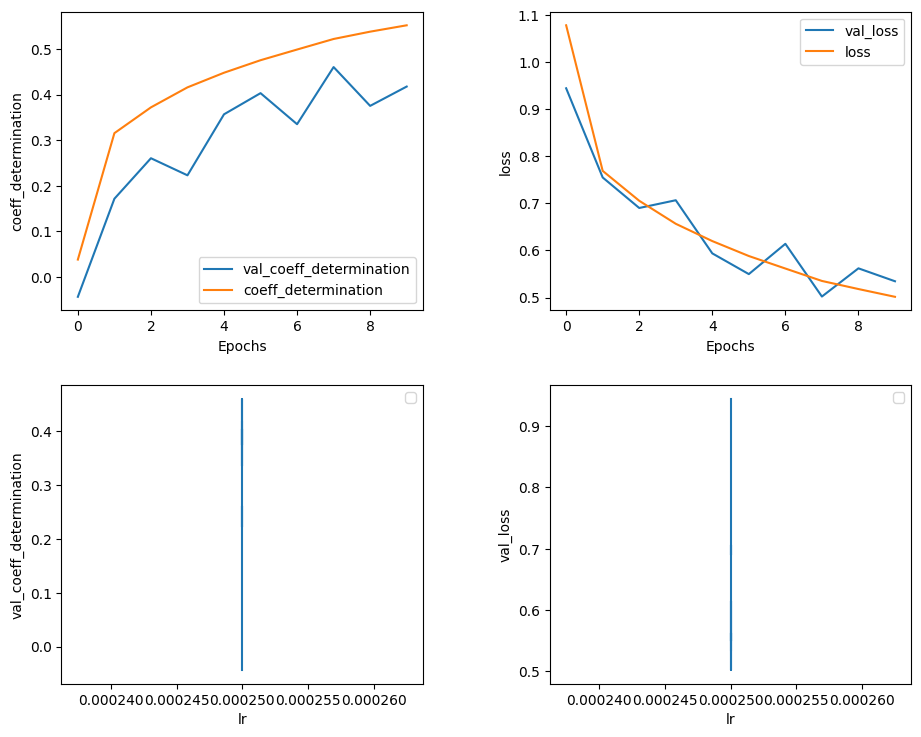

In [98]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(221)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(222)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")



plt.subplot(223)
plt.plot( hist['lr'],hist['val_coeff_determination']  )
plt.legend()
plt.xlabel("lr")
plt.ylabel("val_coeff_determination")


plt.subplot(224)
plt.plot( hist['lr'],hist['val_loss']  )
plt.legend()
plt.xlabel("lr")
plt.ylabel("val_loss")

    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

In [44]:
model.load_weights('/content/weights.best.hdf5')
